# Examples of Texas Hold Em Poker Models

### illustrative examples of poker modeling use cases
> Texas Hold 'Em is one of the most popular forms of poker. The game rules as basically as follows, each player is dealt two cards at the beginning of the round, 3 more cards are then dealt to the middle after a round of betting, these 3 cards are called the flop. Following the flop are two more rounds of single cards being dealt called the flop and the river respectively, in both of these rounds only one more card is dealt to the middle. The goal of the game is to be able to create the highest scoring poker hands using the 2 cards in the players hand and those dealt to the middle.

> I have created two different models to inform decisions during Texas Hold Em. The first takes any input of cards dealt during the different rounds and runs n number (default 1,000) game simulations to determine the probability of winning the round using the input card combinations. For example, an input might be pocket kings and one king dealt in the flop, the model would then return the probability of winning the round given that scenario. 

In [1]:
import pokerUtils

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

sns.set_theme()

In [2]:
from pokerUtils import score_hand, Deck, runSimulation, computeProbability

#### Score a hands
Note, the 'cards' are defined as a letter denoting the suit, ie S->Spades, C->Clubs, etc. The integer denotes the card value, face cards are denoted by 11-14 being Jack, Queen, King, Ace respectively. 

In [3]:
## full house
hand1 = ['C6','D6','H6','D11','H11']
hand2 = ['H11','D11','H2','C4','S10']
hand3 = ['H6','H9','H12','H2','H11']
hand4 = ['H10','C11','H12','D14','C13']

for hand in [hand1,hand2,hand3,hand4]:
    score,handType = score_hand(hand)
    print('score: {}, hand type: {}'.format(round(score,2),handType))

score: 96.11, hand type: full house
score: 26.1, hand type: pair
score: 75.12, hand type: flush
score: 79, hand type: straight


#### Generate a deck and deal some cards
The Deck class can randomly shuffle and generate n number of random selections from the deck, it then automatically removes the dealt cards from the deck.

In [4]:
deck = Deck()

print('first five cards pre-shuffle: {}'.format(deck.deck[0:5]))

deck.shuffle()

print('first five cards post-shuffle: {}'.format(deck.deck[0:5]))

print('number cards in deck before deal: {}'.format(len(deck.deck)))

dealt = deck.dealNumber(5)

print('five cards dealt: {}'.format(dealt))

print('number cards in deck after deal: {}'.format(len(deck.deck)))

first five cards pre-shuffle: ['H2', 'S2', 'C2', 'D2', 'H3']
first five cards post-shuffle: ['D13', 'D3', 'C10', 'D8', 'S3']
number cards in deck before deal: 52
five cards dealt: ['D13', 'D3', 'C10', 'D8', 'S3']
number cards in deck after deal: 47


#### Given specific cards in the hand, or any round, compute probability of winning game based on n number of simulations
The function allows very granular specifications filling in the unspecified with random sampling. For example, the model below show the probability of winning the game if you have pocket kings and one king dealt in the flop for 1000 simulations. 

A single 'simulation' is defined here as a 6 player (can be changed through parameter) game where the 'showdown' off all players is computed. Thus, this models the win probability if all players play through all rounds, there is no modeling of individual bets. The only goal of the outcome is to simulate hands and determine highest scoring. 

In [5]:
simOut = runSimulation(1000,hand=['H13','C13'],flop=['S13'])
print('probability of winning with pocket kings and 1 king dealt on the flop (n=1,000): {}%'.format(
    round(np.sum(simOut)/len(simOut)*100,4)))

probability of winning with pocket kings and 1 king dealt on the flop (n=1,000): 79.5%


In [6]:
simOut = runSimulation(1000,hand=['H13','C13'])
print('probability of winning with pocket kings (n=1,000): {}%'.format(
    round(np.sum(simOut)/len(simOut)*100,4)))

probability of winning with pocket kings (n=1,000): 42.7%


The models below use an increased number of simulations. 

In [7]:
simOut = runSimulation(10000,hand=['H13','C13'],flop=['S13'])
print('probability of winning with pocket kings and 1 king dealt on the flop (n=10,000): {}%'.format(
    round(np.sum(simOut)/len(simOut)*100,4)))

probability of winning with pocket kings and 1 king dealt on the flop (n=10,000): 81.57%


In [8]:
simOut = runSimulation(10000,hand=['H13','C13'])
print('probability of winning with pocket kings (n=10,000): {}%'.format(
    round(np.sum(simOut)/len(simOut)*100,4)))

probability of winning with pocket kings (n=10,000): 44.21%


Increasing the number of simulations from 1000 to 10,000 does not appear to materially change the probabilities, this suggests that sampling bias is low. 

In [9]:
def kelly(probWin):
    return (1* probWin - (1-probWin)) / 1

The kelly criterion is an equation that calculates the percentage of the 'bank roll' to bet given a odds ratio or probability of win and loss. 

In [10]:
print('Kelly % (F%) of bankroll to bet using probability from modeling 3 Kings: {}%'.format(round(kelly(0.82)*100,4)))

Kelly % (F%) of bankroll to bet using probability from modeling 3 Kings: 64.0%


#### Probability that there is any possible combination of un-dealt cards that beats current hand.
This technically computes the distribution of all possible hands excluding the input hand and dealt cards, and then samples that distribution to determine percentile of current hand. 

In [11]:
def percentFormat(a):
    return round(a*100,4)

The model below is showing a full house. 

In [12]:
t1,t2 = computeProbability(['D13','H13'],['C13','H10','S10'])

print('percentile of hand in possible outcomes: {}%, percent chance of loss: {}%'.format(percentFormat(t1),percentFormat(t2)))

percentile of hand in possible outcomes: 76.7669%, percent chance of loss: 23.2331%


In [13]:
print('Kelly F% = {}'.format(percentFormat(kelly(0.46))))

Kelly F% = -8.0


The kelly F% calculated above is for the 46% chance of a win if you have pocket kings. Whats interesting about this is that if you only consider the probability of winning based on the cards dealt to you pre-flop, Kelly may always tell you not to bet. This is the case here because pocket kings suggest that you should fold (kelly F% is negative) but if a king is dealt in the flop then its very positive. 

#### Robustness testing with larger sample size
Examine the robustness of the estimate given larger sample sizes of experiment. 

In [14]:
def runRobustSim():
    simOut = runSimulation(1000,hand=['H13','C13'],flop=['S13'])
    return round(np.sum(simOut)/len(simOut)*100,4)

In [15]:
sims = pd.DataFrame({i: runRobustSim() for i in tqdm(range(100))},index=['probWin'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


In [18]:
simsDf = sims.transpose()
simsDf.head()

,probWin
0,83.9
1,82.4
2,82.6
3,83.1
4,84.1


In [24]:
print('Standard Deviation of 100 runs: {}%'.format(round(simsDf['probWin'].std(),2)))

Standard Deviation of 100 runs: 1.14%


[Text(0.5, 1.0, 'Histogram of probabilities given 100 samples and same input')]

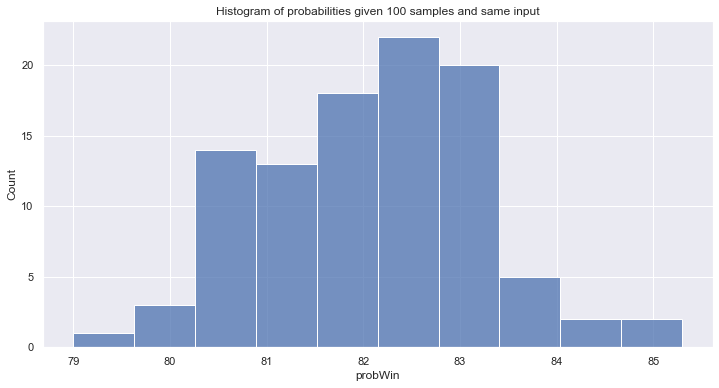

In [38]:
fig,axes = plt.subplots(figsize=(12,6))
sns.histplot(data=simsDf['probWin']).set(title='Histogram of probabilities given 100 samples and same input')

The distribution of probabilities given 100 samples of n=1,000 samples each has a standard deviation of 1% and a very tight distribution. 